# Projeto Titanic Regressão

# Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set(style="white")
import seaborn as sns
from scipy.stats import chi2_contingency
import os

# Importando DataFrame

In [2]:
#Configurando parametros de exibicao do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
#importando DF
df = pd.read_csv('titanic.csv')
df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


# Verificando extrutura geral do DF

In [4]:
#verificando shape
df.shape

(887, 8)

In [5]:
#Verificando classificacao do DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
Survived                   887 non-null int64
Pclass                     887 non-null int64
Name                       887 non-null object
Sex                        887 non-null object
Age                        887 non-null float64
Siblings/Spouses Aboard    887 non-null int64
Parents/Children Aboard    887 non-null int64
Fare                       887 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [6]:
#Verificando Nulls
miss_sum = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns = ['Total'])
miss_percent = pd.DataFrame((df.isnull().sum()/df.isnull().count()*100), columns = ['Percentage'])
missfulldf = pd.concat([miss_sum,miss_percent], axis=1)
print(missfulldf[missfulldf['Total']>0])
print('\n********TOTALS**********\n',missfulldf[missfulldf['Total']>0].count())

Empty DataFrame
Columns: [Total, Percentage]
Index: []

********TOTALS**********
 Total         0
Percentage    0
dtype: int64


/Library/Python/3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [7]:
#Verificando Variaveis com valor = 0
zeros_sum = pd.DataFrame(df[(df==0)].count().sort_values(ascending=False), columns = ['Total'])
zeros_percent = pd.DataFrame((df[(df==0)].count()/df.isnull().count()*100), columns = ['Percentage'])
zerosfulldf = pd.concat([zeros_sum,zeros_percent], axis=1)
print(zerosfulldf[zerosfulldf['Total']>0])
print('\n********TOTALS**********\n',zerosfulldf[zerosfulldf['Total']>0].count())

                         Total  Percentage
Fare                        15    1.691094
Parents/Children Aboard    674   75.986471
Siblings/Spouses Aboard    604   68.094701
Survived                   545   61.443067

********TOTALS**********
 Total         4
Percentage    4
dtype: int64


/Library/Python/3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


* Survived -> 0 e uma possivel entrada
* Siblings/Spouses Aboard -> 0 e uma possivel entrada
* Parents/Children Aboard -> 0 e uma possivel entrada
* **Fare -> Nao exite tarifa 0, precisamos tratar esse dado**

In [8]:
#Convertendo variaveis Name e Sex para categoricas
df = df.astype({'Name':'category','Sex':'category', 'Survived':'category','Pclass':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
Survived                   887 non-null category
Pclass                     887 non-null category
Name                       887 non-null category
Sex                        887 non-null category
Age                        887 non-null float64
Siblings/Spouses Aboard    887 non-null int64
Parents/Children Aboard    887 non-null int64
Fare                       887 non-null float64
dtypes: category(4), float64(2), int64(2)
memory usage: 79.4 KB


In [9]:
#Verificando dados estatistico das variáveis numéricas
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,887.0,29.471443,14.121908,0.42,20.250,28.0000,38.0000,80.0000
Siblings/Spouses Aboard,887.0,0.525366,1.104669,0.00,0.000,0.0000,1.0000,8.0000
Parents/Children Aboard,887.0,0.383315,0.807466,0.00,0.000,0.0000,0.0000,6.0000
Fare,887.0,32.305420,49.782040,0.00,7.925,14.4542,31.1375,512.3292


* Age: Desvido padrão muito alto, idade inferior a 0, assimetria
* Siblings/Spouses: Assimetrico, maioria não tinha parceiro a bordo
* Parents/Children Aboard: Assimetrico, maioria não tinha filhos a bordo
* Fare: Tarifas com 0, desvio padrão alto, assimetria

In [10]:
#Verificando dados estatistico das variáveis categóricas
df.describe(include ='category').T

,count,unique,top,freq
Survived,887,2,0,545
Pclass,887,3,3,487
Name,887,887,the Countess. of (Lucy Noel Martha Dyer-Edward...,1
Sex,887,2,male,573


* Survived: Maoria morreu
* Pclass: Maioria era da 3ra classe
* Name: Não existem entradas com nome duplicados
* Sex: Maioria do sexo masculino

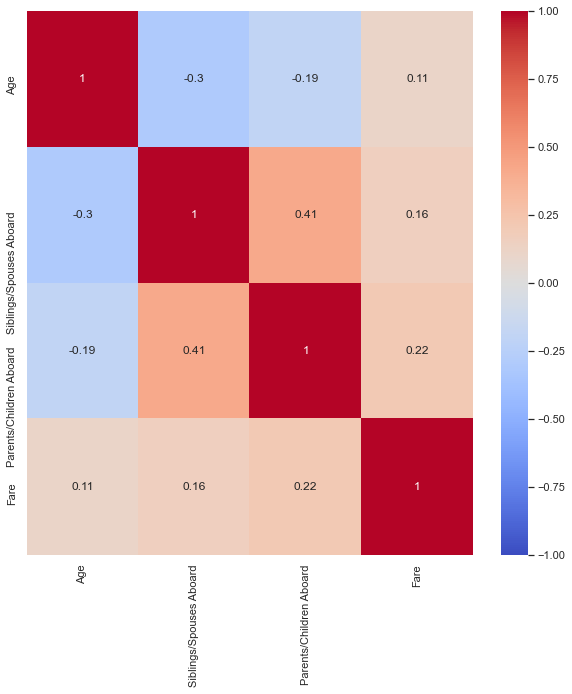

In [11]:
#Verificanndo a correlação entre as variáveis numéricas
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

* Não existe colinearidade

In [12]:
#Verificando a distribuição dos grupos
column = df.columns
for i in column:
    print('***** ',i, '******\n')
    print(df[i].value_counts(),'\n')

*****  Survived ******

0    545
1    342
Name: Survived, dtype: int64 

*****  Pclass ******

3    487
1    216
2    184
Name: Pclass, dtype: int64 

*****  Name ******

the Countess. of (Lucy Noel Martha Dyer-Edwards) Rothes    1
Mr. Benjamin Laventall Foreman                             1
Mr. Charles Alexander Fortune                              1
Mr. Chang Chip                                             1
Mr. Cerin Balkic                                           1
                                                          ..
Mr. Nicholas Nasser                                        1
Mr. Nestor Cyriel Vande Walle                              1
Mr. Nedelio Petroff                                        1
Mr. Neal McNamee                                           1
Capt. Edward Gifford Crosby                                1
Name: Name, Length: 887, dtype: int64 

*****  Sex ******

male      573
female    314
Name: Sex, dtype: int64 

*****  Age ******

22.00    39
28.00    37
18

# Análise de variáveis

In [13]:
#Separando variáveis por tipo para facilitar a análise
featdf = pd.DataFrame(df.dtypes,columns=['Data_Type'])
print('****************************************************************************************************')
print('Category Variables')
print('****************************************************************************************************\n')
print(featdf[featdf['Data_Type']=='category'])
print('\n**Total: ',featdf[featdf['Data_Type']=='category'].count(),'**')
print('\n ****************************************************************************************************')
print('Numerical Variables')
print('****************************************************************************************************\n')
print(featdf[featdf['Data_Type']!='category'])
print('\n**Total: ',featdf[featdf['Data_Type']!='category'].count(),'**')

****************************************************************************************************
Category Variables
****************************************************************************************************

         Data_Type
Survived  category
Pclass    category
Name      category
Sex       category

**Total:  Data_Type    4
dtype: int64 **

 ****************************************************************************************************
Numerical Variables
****************************************************************************************************

                        Data_Type
Age                       float64
Siblings/Spouses Aboard     int64
Parents/Children Aboard     int64
Fare                      float64

**Total:  Data_Type    4
dtype: int64 **


In [14]:
#Gerando listas com variáveis numericas e categóricas
nunfeat = list(featdf[featdf['Data_Type']!='category'].index)
catfeat = list(featdf[featdf['Data_Type']=='category'].index)

## Variáveis Numéricas

/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprec

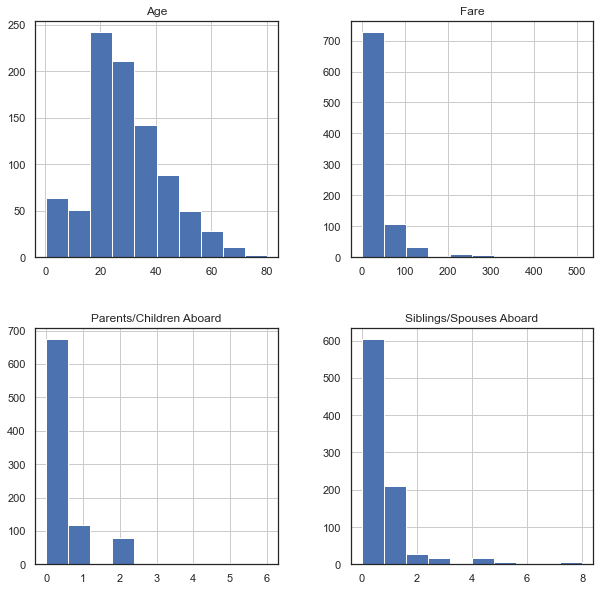

In [15]:
#Histograma
df.hist(figsize=(10,10))
plt.show()

* Todas a variáveis são assimétricas


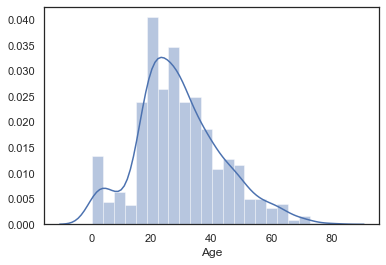

In [16]:
#Gráficos de distribuição
sns.distplot(df['Age'])

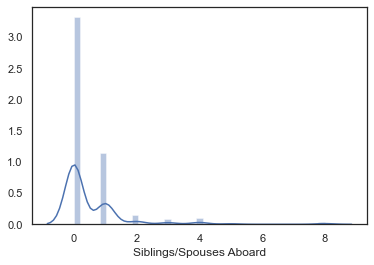

In [17]:
sns.distplot(df['Siblings/Spouses Aboard'])

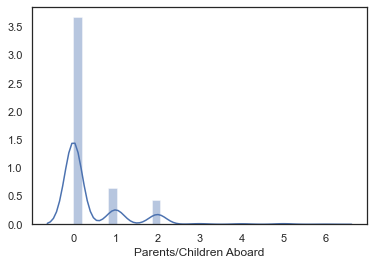

In [18]:
sns.distplot(df['Parents/Children Aboard'])

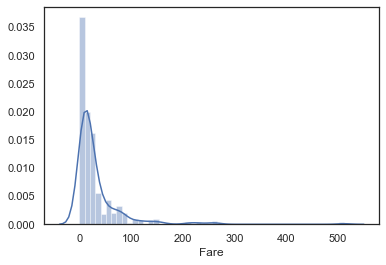

In [19]:
sns.distplot(df['Fare'])

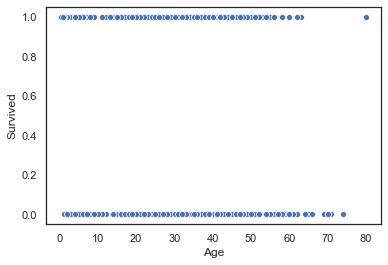

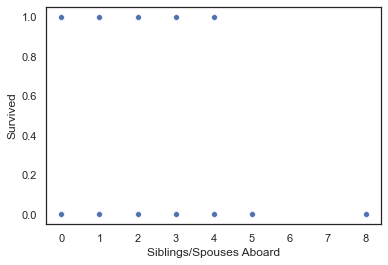

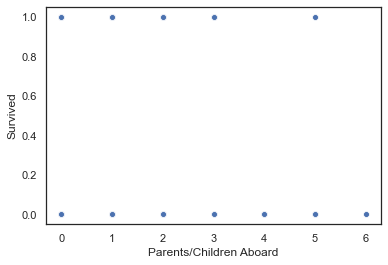

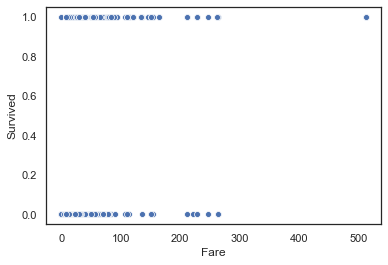

In [20]:
#Grafico de disperção(neste caso como o taget é categórica não é uma boa opção)
for graf in nunfeat:
    sns.scatterplot(x=graf, y='Survived', data=df)
    plt.show()

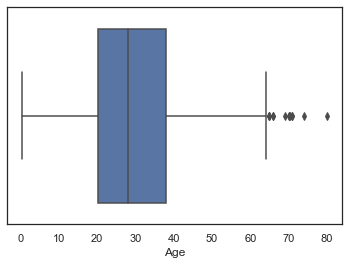

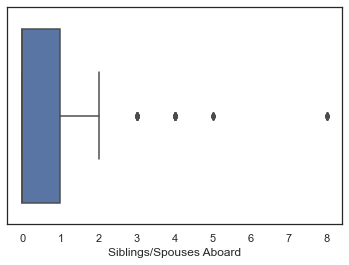

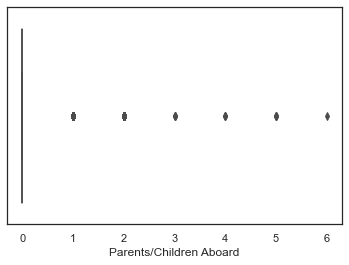

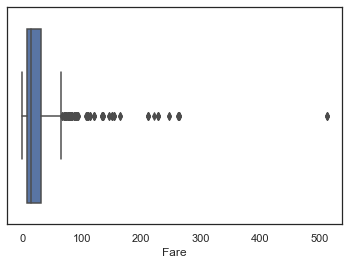

In [21]:
#Grafico boxplot
for graf2 in nunfeat:
    sns.boxplot(df[graf2])
    plt.show()

* Todas as Variáveis tem Ouliers

## Variáveis categoricas

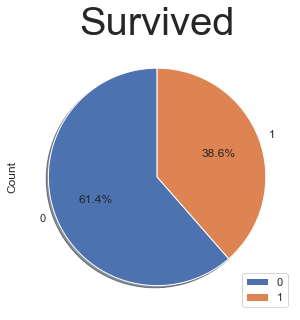

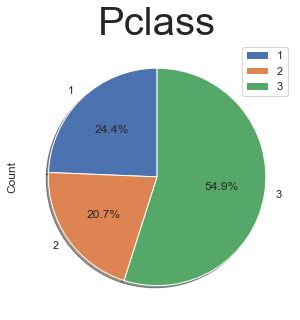

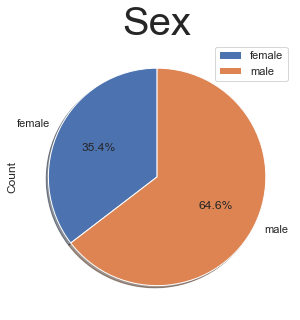

In [22]:
#Gráfico de pizza para verificar a distribuição da variável
dfpie = df.copy()
#Criando coluna com numeros 1 para fazer as somas
dfpie['Count']= 1
for pie in catfeat:
    if pie == 'Name':
        pass
    else:
        dfpie.groupby([pie]).sum().plot(kind='pie', y='Count', shadow = True,startangle=90,\
                                             figsize=(5,5), autopct='%1.1f%%')
        plt.title(pie, fontsize=40)

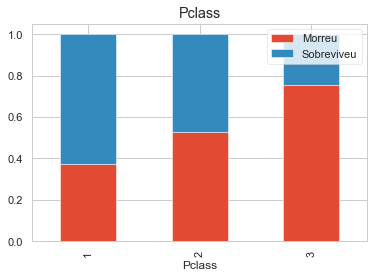

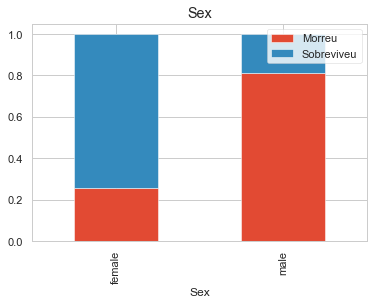

In [56]:
#Gráfico de barras emplilhado para verificar distribuição e correlação com o target
for stk in catfeat:
    if stk == 'Name' or stk == 'Survived':
        pass
    else:
        #Criando uma tabela cruzada com as duas variáveis e usando apply para tranformar em % do total
        dfc= pd.crosstab(df[stk],df['Survived']).apply(lambda r: r/r.sum(), axis = 1)
        #Criando o gráfico bar stacked
        ax1 = dfc.plot(kind = "bar", stacked = True, title = stk)
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines,["Morreu", "Sobreviveu"], loc = 'best')

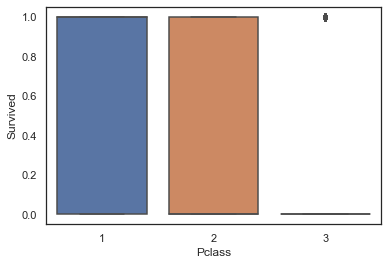

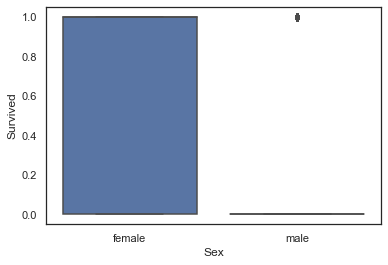

In [23]:
#Verificando boxplot, não muito adequado quando a variável target é categórica
for cgraf in catfeat:
    if cgraf == 'Name' or cgraf == 'Survived' :
        pass
    else:
        sns.boxplot(df[cgraf],df['Survived'].astype(int) )
        plt.show()

In [24]:
#Verificando a correlação pelo teste do Chi_Quadrado
from scipy.stats import chi2_contingency


def chisq_func(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(chi2_contingency(ctsum.fillna(0)))

print('************Chi_Quadrado*****************\n')
pvalues = []
for feat in catfeat:
    if feat == 'Name' or feat == 'Survived' :
        pass
    else:
        print(feat)
        chires = chisq_func(df,feat,'Survived')
        print(chires[1])
        pvalues.append(chires[1])
chidf = pd.DataFrame(pvalues,index=['Pclass','Sex'],columns=['P-Value'])
chidf.sort_values(by='P-Value')

************Chi_Quadrado*****************

Pclass
1.0496962042983216e-22
Sex
3.847574039733745e-58


,P-Value
Sex,3.847574e-58
Pclass,1.049696e-22


* Os P-Valor indicam que a hipotese H1 está confirmada ou seja Pclass e Sex tem correlação com Survived

# Engenharia de dados

## Verificando variáveis com valor 0
* Idade com valores 0
* Fare valores 0

In [25]:
#Verificando e corrigindo variável idade
df['Age'] = df['Age'].replace(df[df['Age']<1]['Age'],df['Age'].mean())
df[df['Age']<1]

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare


In [26]:
#Verificando e corrigindo 0 na tarifa de acordo com a classe
#Criando medias por classe
medias=df.groupby('Pclass').mean()['Fare']
classe1 = medias[0].round(2)
classe2 = medias[2].round(2)
classe3 = medias[3].round(2)
df['Fare'] = df['Fare'].replace(df[(df['Pclass']== 3)&(df['Fare'] == 0)]['Fare'],classe3)
df['Fare'] = df['Fare'].replace(df[(df['Pclass']== 2)&(df['Fare'] == 0)]['Fare'],classe2)
df['Fare'] = df['Fare'].replace(df[(df['Pclass']== 1)&(df['Fare'] == 0)]['Fare'],classe1)

df[df['Fare']<=0]

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare


## Verificando assimetrias

In [27]:
#Classificando variáveis numericas de acordo com sua assimetria
skewed_feats = df[nunfeat].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_feats

Fare                       4.748929
Siblings/Spouses Aboard    3.686760
Parents/Children Aboard    2.741198
Age                        0.491291
dtype: float64

In [28]:
#Padronizando o dado com BOXCOX
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skewt = skewed_feats[skewed_feats > 0.5]
skew_index = high_skewt.index

# Normalise skewed features
for i in skew_index:
    boxcox_lambda = boxcox_normmax(df[i] + 1)
    print(i, ' LAMBDA: ',boxcox_lambda, '\n' )
    df[i] = boxcox1p(df[i], boxcox_lambda)

Fare  LAMBDA:  -0.496538445965824 

Siblings/Spouses Aboard  LAMBDA:  -0.52624850372354 

Parents/Children Aboard  LAMBDA:  -0.2396120883251585 



/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Library/Python/3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprec

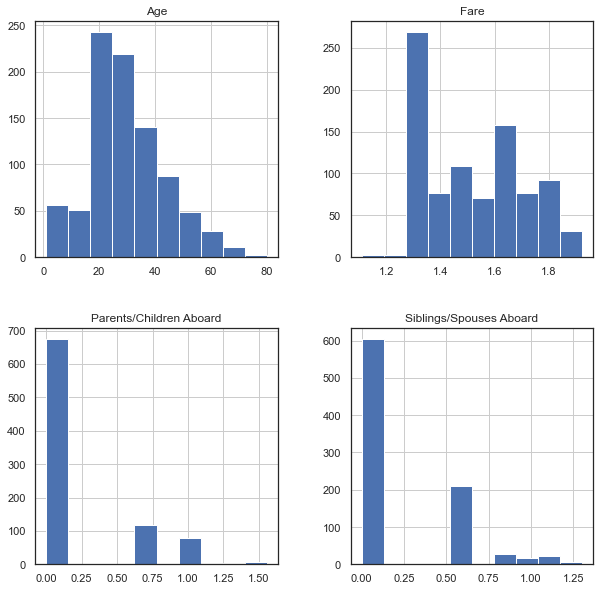

In [29]:
#Histograma, para verificar o resultado da normalização
df.hist(figsize=(10,10))
plt.show()

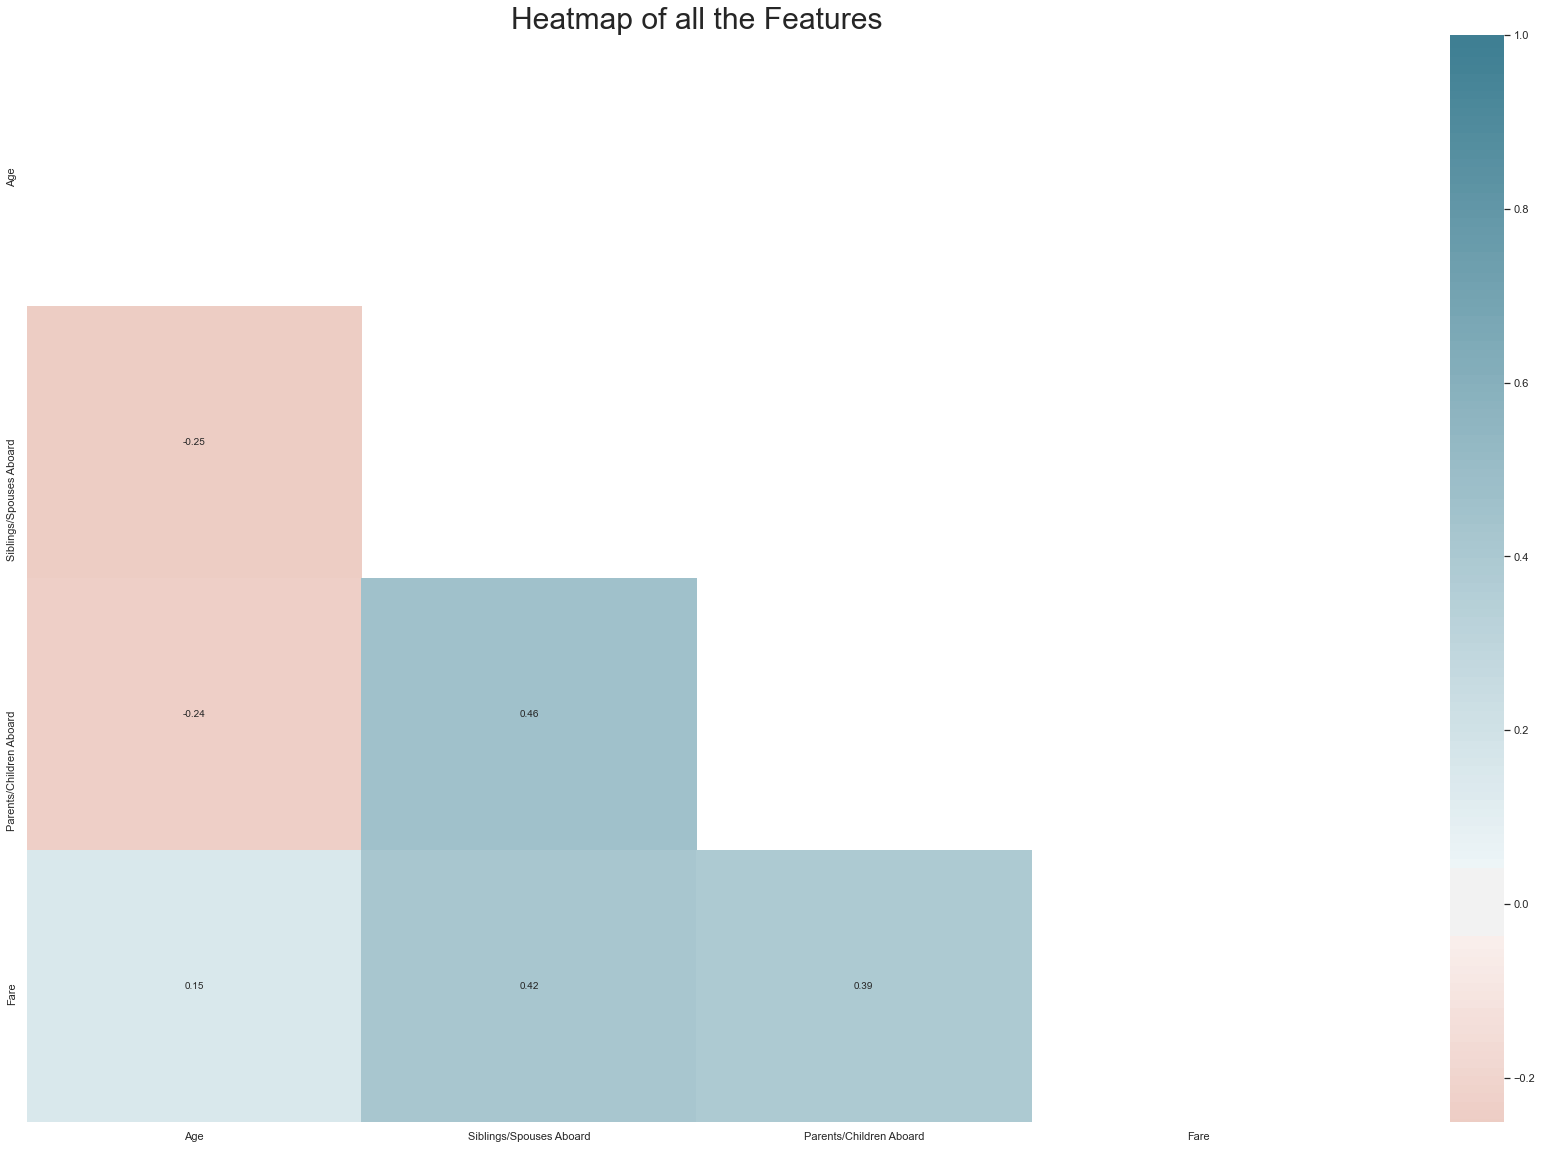

In [30]:
#Ultima olhada nas correlações das variáveis numéricas
import matplotlib.style as style
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
 
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0, );
plt.title("Heatmap of all the Features", fontsize = 30);

## Convertendo dados categóricos em dummie

In [31]:
df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,0.580794,0.000000,1.307637
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,0.580794,0.000000,1.773527
2,1,3,Miss. Laina Heikkinen,female,26.0,0.000000,0.000000,1.334687
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,0.580794,0.000000,1.736324
4,0,3,Mr. William Henry Allen,male,35.0,0.000000,0.000000,1.339361
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0.000000,0.000000,1.470754
883,1,1,Miss. Margaret Edith Graham,female,19.0,0.000000,0.000000,1.647903
884,0,3,Miss. Catherine Helen Johnston,female,7.0,0.580794,0.965908,1.602117
885,1,1,Mr. Karl Howell Behr,male,26.0,0.000000,0.000000,1.647903


In [32]:
#Removendo nomes e survived
df2 = df.drop(['Name','Survived'], axis=1)
#Criando dummies
df_dummie = pd.get_dummies(df2).reset_index(drop=True)
df_dummie

,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,0.580794,0.000000,1.307637,0,0,1,0,1
1,38.0,0.580794,0.000000,1.773527,1,0,0,1,0
2,26.0,0.000000,0.000000,1.334687,0,0,1,1,0
3,35.0,0.580794,0.000000,1.736324,1,0,0,1,0
4,35.0,0.000000,0.000000,1.339361,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
882,27.0,0.000000,0.000000,1.470754,0,1,0,0,1
883,19.0,0.000000,0.000000,1.647903,1,0,0,1,0
884,7.0,0.580794,0.965908,1.602117,0,0,1,1,0
885,26.0,0.000000,0.000000,1.647903,1,0,0,0,1


In [33]:
#Verificando o shape do nossos DF
#Checking overall result and DF Shape
print('DF', df.shape)
print('Dummie DF ', df_dummie.shape)

DF (887, 8)
Dummie DF  (887, 9)


# Aplicando Machine Learning

In [93]:
#Separando dados de treino e teste
# Seleção de variáveis preditoras 
atributos2 = list(df_dummie.columns)
# Selection the target feature
atrib_prev2 = ['Survived']
# Creating objetcs for ML
X2 = df_dummie[atributos2].values
Y2 = df[atrib_prev2].values
# Definindo taxa de split
split_test_size = 0.30
#Criando objetos de treino e teste
from sklearn.model_selection import train_test_split
X2_treino, X2_teste, Y2_treino, Y2_teste = train_test_split(X2, Y2, test_size = split_test_size, random_state = 42)

#Printing out the Test and Train frames information
print("\n******************************************************************************")
print("Imprimindo os dados de treino e teste")
print("{0:0.2f}% nos dados de treino".format((len(X2_treino)/len(df_dummie.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X2_teste)/len(df_dummie.index)) * 100))
print("******************************************************************************\n")

results=[]

# Utilizando um classificador Naive Bayes
print("\n******************************************************************************")
print("Utilizando um classificador Naive Bayes")
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Criando o modelo preditivo
modelo_v1 = GaussianNB()
# Treinando o modelo
modelo_v1.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v1_train = modelo_v1.predict(X2_treino)
print("Exatidão TREINO Naive Bayes (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v1_train)))
# Verificando nos dados de teste
modelo_v1_test = modelo_v1.predict(X2_teste)
print("\nExatidão TESTE Naive Bayes(Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v1_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v1_test).round(2))

# ALGORITMO DE REGRESSAO LOGISTICA
print("\n******************************************************************************")
print("Utilizando um classificador Regressao Logistica")
from sklearn.linear_model import LogisticRegression
# versão do modelo usando Regressão Logística
#C hist - C = 0.7
modelo_v2 = LogisticRegression(C = 1e4, random_state = 42)
modelo_v2.fit(X2_treino, Y2_treino.ravel())
lr_predict_train = modelo_v2.predict(X2_treino)
# Verificando os dados de treino
modelo_v2_train = modelo_v2.predict(X2_treino)
print("Exatidão TREINO Regressao Logistica (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v2_train)))
# Verificando nos dados de teste
modelo_v2_test = modelo_v2.predict(X2_teste)
print("\nExatidão TESTE Regressao Logistica (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v2_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v2_test).round(2))

# ALGORITMO RANDOM FORREST
print("\n******************************************************************************")
print("Utilizando um classificador Random Forrest")
from sklearn.ensemble import RandomForestClassifier
modelo_v4 = RandomForestClassifier(random_state = 40, n_jobs=10)
modelo_v4.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v4_train = modelo_v4.predict(X2_treino)
print("Exatidão TREINO Random Forrest (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v4_train)))
# Verificando nos dados de teste
modelo_v4_test = modelo_v4.predict(X2_teste)
print("\nExatidão TESTE Random Forrest (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v4_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v4_test).round(3))

# ALGORITMO RkNN (k-Nearest Neighbors)
print("\n******************************************************************************")
print("Utilizando um classificador kNN (k-Nearest Neighbors)")
from sklearn.neighbors import KNeighborsClassifier
modelo_v5=KNeighborsClassifier(n_neighbors=5)
modelo_v5.fit(X2_treino, Y2_treino.ravel())
# Verificando os dados de treino
modelo_v5_train = modelo_v5.predict(X2_treino)
print("Exatidão TREINO kNN (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_treino, modelo_v5_train)))
# Verificando nos dados de teste
modelo_v5_test = modelo_v5.predict(X2_teste)
print("\nExatidão TESTE kNN (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, modelo_v5_test)))
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, modelo_v5_test).round(2))

# Gradient Boosting Classifier
print("\n******************************************************************************")
print("Utilizando um classificador Gradient Boosting Classifier")
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X2_treino, Y2_treino)
gbk_pred = gbk.predict(X2_teste)
# Verificando nos dados de teste
acc_gbk = round(accuracy_score(gbk_pred, Y2_teste) * 100, 2)

print("\nExatidão Gradient Boosting Classifier (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, gbk_pred)))
print(acc_gbk)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, gbk_pred).round(3))

# Stochastic Gradient Descent
print("\n******************************************************************************")
print("Utilizando um classificador Stochastic Gradient Descent")
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X2_treino, Y2_treino)
y_pred = sgd.predict(X2_teste)
acc_sgd = round(accuracy_score(y_pred, Y2_teste) * 100, 2)
print("\nExatidão Stochastic Gradient Descent (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, y_pred)))
print(acc_sgd)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, y_pred).round(2))

# Random Forest 2
print("\n******************************************************************************")
print("Utilizando um classificador Random Forest 2")
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()
randomforest.fit(X2_treino, Y2_treino)
y_pred = randomforest.predict(X2_teste)
acc_randomforest = round(accuracy_score(y_pred, Y2_teste) * 100, )
print("\nExatidão Random Forest 2 (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, y_pred)))
print(acc_randomforest)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, y_pred).round(3))

#Decision Tree
print("\n******************************************************************************")
print("Utilizando um classificador Decision Tree")
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X2_treino, Y2_treino)
y_pred = decisiontree.predict(X2_teste)
acc_decisiontree = round(accuracy_score(y_pred, Y2_teste) * 100, 2)
print("\nExatidão Decision Tree (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, y_pred)))
print(acc_decisiontree)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, y_pred).round(2))

# Linear SVC
print("\n******************************************************************************")
print("Utilizando um classificador Linear SVC")
from sklearn.svm import LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X2_treino, Y2_treino)
y_pred = linear_svc.predict(X2_teste)
acc_linear_svc = round(accuracy_score(y_pred, Y2_teste) * 100, 2)
print("\nExatidão Linear SVC(Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, y_pred)))
print(acc_linear_svc)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, y_pred).round(2))

# Support Vector Machines
print("\n******************************************************************************")
print("Utilizando um classificador Support Vector Machines")
from sklearn.svm import SVC

svc = SVC()
svc.fit(X2_treino, Y2_treino)
y_pred = svc.predict(X2_teste)
acc_svc = round(accuracy_score(y_pred, Y2_teste) * 100, 2)
print("\nExatidão Support Vector Machines (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y2_teste, y_pred)))
print(acc_svc)
print("******************************************************************************\n")
results.append(metrics.accuracy_score(Y2_teste, y_pred).round(2))
modelsdf = pd.DataFrame(results,index=['NaiveBayes','RegrLog','RndFrst1','RkNN','GBC','SGD','RndFrst2','DecTree','SVC1','SVC2']\
                        , columns=['Exatidao'])



******************************************************************************
Imprimindo os dados de treino e teste
69.90% nos dados de treino
30.10% nos dados de teste
******************************************************************************


******************************************************************************
Utilizando um classificador Naive Bayes
Exatidão TREINO Naive Bayes (Accuracy): 0.7871

Exatidão TESTE Naive Bayes(Accuracy): 0.7603
******************************************************************************


******************************************************************************
Utilizando um classificador Regressao Logistica
Exatidão TREINO Regressao Logistica (Accuracy): 0.8129

Exatidão TESTE Regressao Logistica (Accuracy): 0.7528
******************************************************************************


******************************************************************************
Utilizando um classificador Random Forrest
Exatidão TREINO

/Library/Python/3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Exatidão Gradient Boosting Classifier (Accuracy): 0.8052
80.52
******************************************************************************


******************************************************************************
Utilizando um classificador Stochastic Gradient Descent

Exatidão Stochastic Gradient Descent (Accuracy): 0.7154
71.54
******************************************************************************


******************************************************************************
Utilizando um classificador Random Forest 2

Exatidão Random Forest 2 (Accuracy): 0.7828
78.0
******************************************************************************


******************************************************************************
Utilizando um classificador Decision Tree

Exatidão Decision Tree (Accuracy): 0.7491
74.91
******************************************************************************


***********************************************************************

/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Python/3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [94]:
modelsdf.sort_values(by = 'Exatidao', ascending=False)

,Exatidao
GBC,0.805
RndFrst1,0.790
RndFrst2,0.783
NaiveBayes,0.760
RkNN,0.760
RegrLog,0.750
DecTree,0.750
SVC1,0.740
SGD,0.720
SVC2,0.620


* O Algoritmo Gradient Boosting Classifier teve o melhor desempenho nesta tarefa, com uma exatidão de 80% nos dados desconhecidos.

## Verificando a Matriz de Confusão para Gradient Boosting Classifier

In [125]:
#Imprimindo e analisando a Matriz de confusão
print("************************************************************************************")
print("Matriz de Confusão\n")
dado = metrics.confusion_matrix(Y2_teste, gbk_pred, labels = [1, 0])
dfco = pd.DataFrame(dado, index = [1,0], columns = [1,0])
print(dfco)
print("************************************************************************************")

print("************************************************************************************")
print("                   Relatório de Classificação\n")
print(metrics.classification_report(Y2_teste, gbk_pred, labels = [1, 0]))
print("************************************************************************************")

************************************************************************************
Matriz de Confusão

    1    0
1  68   33
0  19  147
************************************************************************************
************************************************************************************
                   Relatório de Classificação

              precision    recall  f1-score   support

           1       0.78      0.67      0.72       101
           0       0.82      0.89      0.85       166

    accuracy                           0.81       267
   macro avg       0.80      0.78      0.79       267
weighted avg       0.80      0.81      0.80       267

************************************************************************************
